## Import dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_predict
from importlib import reload
import forward_stepwise

import warnings
warnings.filterwarnings("ignore")

## Read data

In [4]:
df_EL = pd.read_csv("../data/enol_EL_set.csv")

In [5]:
non_features = ['ligand_entry', 'SMILES_FL', 'ligand_type', 'exp_yield', 'exp_ee', 'exp_deldelG']  # non-features

In [6]:
X_train = df_EL.drop(columns = non_features)  # storing features
y_train = df_EL['exp_deldelG']  # storing label

In [7]:
corr_threshold = 0.9  # setting correlation threshold value

In [8]:
mask = np.abs(X_train.corr()) > corr_threshold

columns = np.full((mask.shape[0],), True, dtype = bool)

for i in range(mask.shape[0]):
    for j in range(i+1, mask.shape[0]):
        if mask.iloc[i,j]:
            if columns[j]:
                columns[j] = False

selected_columns = X_train.columns[columns]  # selecting features with corr below the threshold
df_features = X_train[selected_columns]

In [9]:
df_features.columns.tolist()  # features with corr below the threshold

['nbo_O1_CMC',
 'nbo_X3_CMC',
 'nbo_C4_CMC',
 'nbo_N5_CMC',
 'nbo_C6_CMC',
 'nbo_C7_CMC',
 'nbo_O8_CMC',
 'da_C2_X3_C4_N5_CMC',
 'bl_OCo_CMC',
 'vbur_Co_CMC',
 'vbur_oct2_CMC',
 'vbur_oct7_CMC',
 'IE_CMC',
 'nbo_O1_FL',
 'nbo_C4_FL',
 'nbo_N5_FL',
 'da_C2_X3_C4_N5_FL',
 's_C2_Bmin_FL',
 's_C2_Bmax_FL',
 's_C2_L_FL',
 's_C6_Bmin_FL',
 's_C6_L_FL']

In [10]:
# features with corr above the threshold
features_to_drop = list(set(X_train.columns.tolist()) - set(df_features.columns.tolist()))
features_to_drop

['nbo_O8_FL',
 'nbo_C2_CMC',
 'nbo_C2_FL',
 'nbo_C7_FL',
 's_C6_Bmax_FL',
 'vbur_oct3_CMC',
 'vbur_oct6_CMC',
 'ba_OCoN_CMC',
 'bl_NCo_CMC',
 'vbur_oct5_CMC',
 'nbo_X3_FL',
 'nbo_Co_CMC',
 'nbo_C6_FL',
 'vbur_oct4_CMC']

In [11]:
X_train_2 = df_features.copy(deep=True)
X_train_2.shape

(11, 22)

## Multivariate modeling

In [13]:
reload(forward_stepwise)  # see forward_stepwise.py file

<module 'forward_stepwise' from 'C:\\Users\\neera\\Desktop\\github_files\\scripts\\forward_stepwise.py'>

In [14]:
top_models = forward_stepwise.forward_stepwise_model_selector(X_train_2, y_train, max_features=3)  # for number of features=3

Step 1:
Selected feature: IE_CMC
Train MAE: 0.32955605211178746, Train R2: 0.5995242420262288
LOO MAE: 0.42307444756423285, 3-fold CV MAE: 0.538621486983292
Selected features: IE_CMC
Coefficients: [-282.93607816]
Intercept: -0.9894227867525542

Step 2:
Selected feature: vbur_oct2_CMC
Train MAE: 0.2604293504347513, Train R2: 0.7375937011340408
LOO MAE: 0.36464155322592456, 3-fold CV MAE: 0.47141056394640196
Selected features: IE_CMC, vbur_oct2_CMC
Coefficients: [-204.75902637    0.4830648 ]
Intercept: -1.894236557145351

Step 3:
Selected feature: nbo_O8_CMC
Train MAE: 0.2014848430396525, Train R2: 0.8323333143927333
LOO MAE: 0.31407607000721394, 3-fold CV MAE: 0.5071003902983645
Selected features: IE_CMC, vbur_oct2_CMC, nbo_O8_CMC
Coefficients: [-131.68275343    0.77150747  -23.2870556 ]
Intercept: -12.946277905684166



In [15]:
loo = LeaveOneOut()

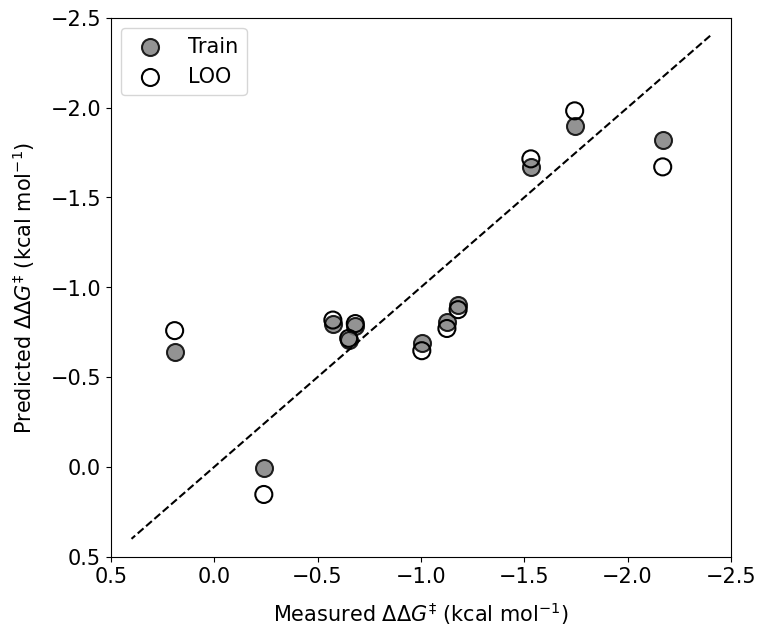

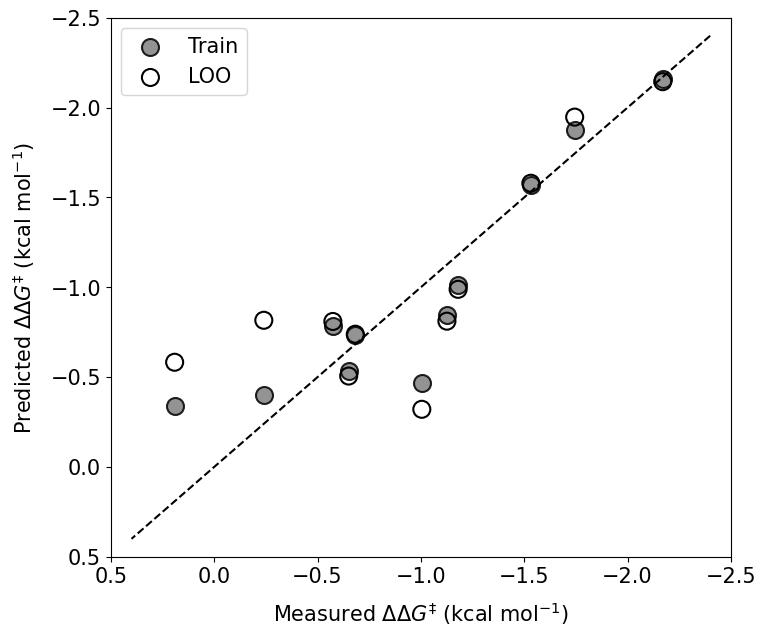

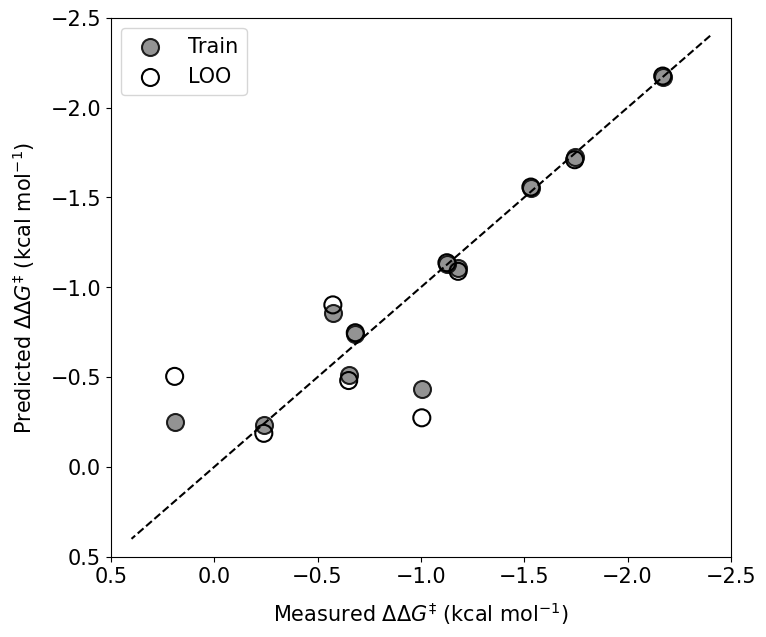

In [16]:
# for each model in top_models
for step, (mae_train, r2_train, mae_loo, mae_3fold, model, subset_indices, subset_names) in enumerate(top_models):
    X_train_subset = X_train_2[subset_names]

    y_train_pred = model.predict(X_train_subset)  # predictions for train set

    y_train_loo = cross_val_predict(model, X_train_subset, y_train, cv=loo)  # predictions for Leave-one-out (LOO) samples

    plt.figure(figsize=(8, 7))

    plt.scatter(y_train, y_train_pred,
                s=150, linewidths=1.5, facecolor='grey', edgecolors='k', alpha=0.85, label='Train')  # train plot

    plt.scatter(y_train, y_train_loo, linewidths=1.5, facecolors='none', edgecolors='k', label='LOO', s=150)  # LOO plot

    plt.plot([-2.4, 0.4], [-2.4, 0.4], 'k--', lw=1.5)  # ideal reference line

    plt.xlabel(r'Measured $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=15, labelpad=10)
    plt.ylabel(r'Predicted $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=15, labelpad=10)

    plt.xlim(-2.5, 0.5)
    plt.ylim(-2.5, 0.5)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.legend(facecolor="white", fontsize=15, loc='upper left')
    plt.grid(False)

    plt.savefig(f'model{step+1}.png', dpi=300, bbox_inches='tight')

    plt.show()

## Model extrapolation

In [18]:
df_EL_external = pd.read_csv("../data/enol_EL_external.csv")

In [19]:
second_model_info = top_models[1]  # access the top two-feature model

# model extraction and feature selection
model = second_model_info[4]
selected_features = second_model_info[6]

X_external = df_EL_external[selected_features]  # extracting the corresponding features from the external set

y_external_pred = model.predict(X_external)  # external set prediction

print(y_external_pred)

[-0.56559767 -1.80658293 -1.58733925]


In [20]:
# constants (unit)
R = 1.987  # cal/mol/K
T = 298.15  # K

deldelG_pred = y_external_pred  # predicted ΔΔG‡ values in kcal/mol
deldelG_pred_cal = deldelG_pred * 1000  # kcal/mol to cal/mol

enantiomeric_ratio = np.exp(-deldelG_pred_cal / (R * T))  # for enantiomeric ratio
enantiomeric_excess = (enantiomeric_ratio - 1) / (enantiomeric_ratio + 1) * 100  # for enantiomeric excess

# results for each ligand
for i, (deldelG, er, ee) in enumerate(zip(deldelG_pred, enantiomeric_ratio, enantiomeric_excess)):
    print(f"Prediction {i + 1}:")
    print(f"ΔΔG‡ (kcal/mol): {deldelG:.2f}")
    print(f"Enantiomeric Ratio (e.r.): {er:.2f}")
    print(f"Enantiomeric Excess (e.e.): {ee:.2f}%\n")


Prediction 1:
ΔΔG‡ (kcal/mol): -0.57
Enantiomeric Ratio (e.r.): 2.60
Enantiomeric Excess (e.e.): 44.41%

Prediction 2:
ΔΔG‡ (kcal/mol): -1.81
Enantiomeric Ratio (e.r.): 21.10
Enantiomeric Excess (e.e.): 90.95%

Prediction 3:
ΔΔG‡ (kcal/mol): -1.59
Enantiomeric Ratio (e.r.): 14.58
Enantiomeric Excess (e.e.): 87.16%



Predicted Train Samples:
[-0.78607688 -0.73283325 -0.33810389 -0.53161019 -0.46856639 -1.87714274
 -2.15842099 -0.40103546 -1.01096987 -1.56702536 -0.84361062]

Predicted LOO Samples:
[-0.80978596 -0.73883864 -0.58273766 -0.50592534 -0.32088586 -1.94715178
 -2.14436949 -0.81640491 -0.98864092 -1.57904302 -0.81143348]

Predicted 3-Fold Samples:
[-0.99381759 -0.97626748 -0.79015522 -0.87906878 -0.21832423 -1.96316203
 -2.73054818 -0.96566164 -0.94945413 -1.54058583 -0.78541128]


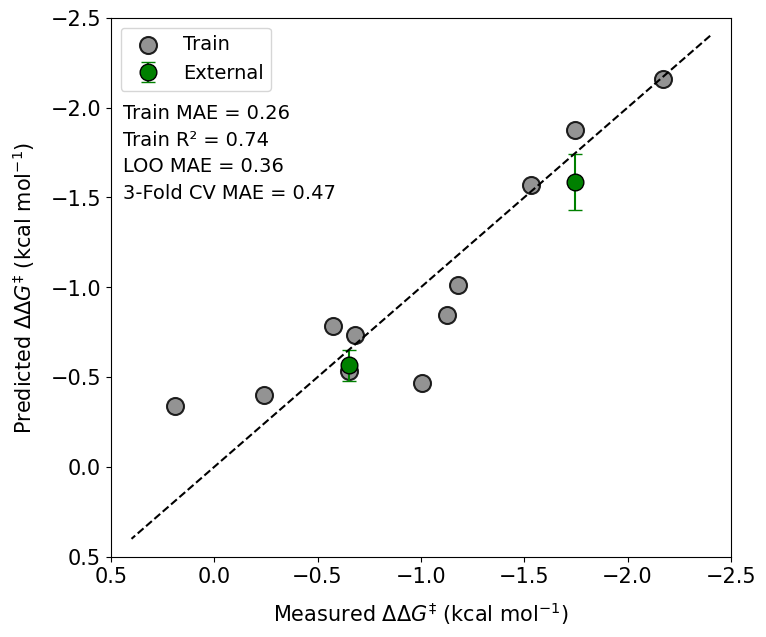

In [21]:
# for plotting with new predictions

second_model_info = top_models[1]
model = second_model_info[4]
selected_features = second_model_info[6]

X_train_subset = X_train_2[selected_features] 
y_train_pred = model.predict(X_train_subset)

loo = LeaveOneOut()
y_train_loo = cross_val_predict(model, X_train_subset, y_train, cv=loo)

kf = KFold(n_splits=3)
y_train_3fold = cross_val_predict(model, X_train_subset, y_train, cv=kf)

X_external_filtered = df_EL_external.iloc[[0, 2]][selected_features]  # EL13 is excluded due to trace amount
y_test_pred_filtered = model.predict(X_external_filtered)  # predictions for plotting EL12 and EL14

y_test_actual_filtered = np.array([-0.650844341, -1.744356465])  # measured ΔΔG‡ values for EL12 and EL14

error_margins_filtered = abs(y_test_pred_filtered - y_test_actual_filtered)  # error bars

# for individual predictions
print("Predicted Train Samples:")
print(y_train_pred)
print("\nPredicted LOO Samples:")
print(y_train_loo)
print("\nPredicted 3-Fold Samples:")
print(y_train_3fold)

plt.figure(figsize=(8, 7))

plt.scatter(y_train, y_train_pred, s=150, linewidths=1.5, facecolor='grey', edgecolors='k', alpha=0.85, label='Train')


# plt.scatter(y_train, y_train_loo, linewidths=1.5, facecolors='none', edgecolors='k', label='LOO', s=150)

# for external set with error bars
plt.errorbar(y_test_actual_filtered, y_test_pred_filtered, yerr=error_margins_filtered, fmt='o',
             color='green', ecolor='green', elinewidth=1.5, capsize=5, label='External',
             markersize=12, markeredgecolor='k', markerfacecolor='green')

plt.plot([-2.4, 0.4], [-2.4, 0.4], 'k--', lw=1.5)  # ideal reference line

plt.xlabel(r'Measured $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=15, labelpad=10)
plt.ylabel(r'Predicted $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=15, labelpad=10)

plt.xlim(-2.5, 0.5)
plt.ylim(-2.5, 0.5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tick_params(axis='both', which='major', labelsize=15)

metrics_text = (f"Train MAE = {second_model_info[0]:.2f}\n"
                f"Train R² = {second_model_info[1]:.2f}\n"
                f"LOO MAE = {second_model_info[2]:.2f}\n"
                f"3-Fold CV MAE = {second_model_info[3]:.2f}")
plt.text(0.02, 0.84, metrics_text, fontsize=14, verticalalignment='top', linespacing=1.5, transform=plt.gca().transAxes)

plt.legend(facecolor="white", fontsize=14, loc='upper left')
plt.grid(False)

plt.savefig('final_model_with_external.png', dpi=300, bbox_inches='tight')

plt.show()

### For model interpretation

In [23]:
# on standardized scale

selected_features = second_model_info[6] 
X_train_subset = X_train_2[selected_features]

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_subset)

model_standardized = model.fit(X_train_standardized, y_train)

# model coefficients and intercept
coefficients_standardized = model_standardized.coef_
intercept_standardized = model_standardized.intercept_

print(f"Standardized Model: {coefficients_standardized[0]:.4f} * {selected_features[0]} + {coefficients_standardized[1]:.4f} * {selected_features[1]}")
print(f"Intercept: {intercept_standardized:.4f}")

Standardized Model: -0.4016 * IE_CMC + 0.2588 * vbur_oct2_CMC
Intercept: -0.9741
